In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

"""import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))"""

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"import os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [35]:
import tensorflow as tf 
import os 

In [36]:
def load_image(image_path, target_size=(256, 256)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = (image / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

def load_dataset(directory, target_size=(256, 256)):
    high_light_dir = os.path.join(directory, 'high')
    low_light_dir = os.path.join(directory, 'low')
    
    high_light_images = [os.path.join(high_light_dir, img) for img in os.listdir(high_light_dir)]
    low_light_images = [os.path.join(low_light_dir, img) for img in os.listdir(low_light_dir)]
    
    high_light_dataset = tf.data.Dataset.from_tensor_slices(high_light_images)
    low_light_dataset = tf.data.Dataset.from_tensor_slices(low_light_images)
    
    high_light_dataset = high_light_dataset.map(lambda x: load_image(x, target_size))
    low_light_dataset = low_light_dataset.map(lambda x: load_image(x, target_size))
    
    return high_light_dataset, low_light_dataset

In [37]:
def random_crop(image):
    cropped_image = tf.image.random_crop(image,size=[256,256,3])

    return cropped_image

def random_jitter(image):
    image = tf.image.resize(image, [286, 286],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
    image = random_crop(image)

  # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

In [38]:
train_dir = '/kaggle/input/lol-dataset/lol_dataset/our485'
val_dir = '/kaggle/input/lol-dataset/lol_dataset/eval15'

train_high_light_dataset, train_low_light_dataset = load_dataset(train_dir)
val_high_light_dataset, val_low_light_dataset = load_dataset(val_dir)

# Combine high and low light datasets
train_dataset = tf.data.Dataset.zip((train_low_light_dataset, train_high_light_dataset))
val_dataset = tf.data.Dataset.zip((val_low_light_dataset, val_high_light_dataset))

# Optional: Shuffle and batch the datasets
batch_size = 4

In [39]:
def create_augmented_dataset(dataset):
    augmented_images = []
    augmented_labels = []
    
    for image, label in dataset:
        augmented_image = random_jitter(image)
        augmented_images.append(augmented_image)
        augmented_labels.append(label)
    
    # Convert lists to tensors
    augmented_images = tf.stack(augmented_images)
    augmented_labels = tf.stack(augmented_labels)
    
    # Create a new tf.data.Dataset from augmented data
    augmented_dataset = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))
    return augmented_dataset

In [40]:
augmented_dataset = create_augmented_dataset(train_dataset)

# Append the augmented dataset to the original training dataset
train_dataset = train_dataset.concatenate(augmented_dataset)


In [41]:
train_dataset = train_dataset.shuffle(buffer_size=100).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [42]:
print(len(train_dataset))
print(len(val_dataset))

243
4


In [43]:

from tensorflow.keras.applications import VGG19

"""vgg = VGG19(include_top=False, input_shape=input_shape)
    for layer in vgg.layers:
        layer.trainable = False
    
    # Extract layers for the downsampling part of the generator
    x = vgg(inputs)
    """
    

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Input, BatchNormalization, Dropout, Concatenate
from tensorflow.keras.models import Model


def build_generator(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    # Downsample
    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs) 
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x) 
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x) 
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(512, kernel_size=4, strides=2, padding='same')(x) 
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x= Dropout(0.4)(x)
    
    x = Conv2D(1024, kernel_size=4, strides=2, padding='same')(x) 
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
  
    
    # Bottleneck
    x = Conv2D(1024, kernel_size=4, strides=1, padding='same')(x)  
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    

    # Upsample
    x = Conv2DTranspose(1024, kernel_size=4, strides=2, padding='same')(x)  
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, kernel_size=4, strides=2, padding='same')(x)  
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)  
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)  
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2DTranspose(32, kernel_size=4, strides=2, padding='same')(x)  
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x=Dropout(0.4)(x)
    
    # Output layer
    outputs = Conv2DTranspose(3, kernel_size=3, strides=1, padding='same', activation='tanh')(x)  # 400x600
    
    return Model(inputs, outputs)

G = build_generator()
G.summary()

F = build_generator()
    

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_36 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_37 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_38 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 16, 16, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_39 (LeakyReLU)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 8, 8, 1024)     │     8,389,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 8, 8, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_40 (LeakyReLU)      │ (None, 8, 8, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 8, 8, 1024)     │    16,778,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 8, 8, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_41 (LeakyReLU)      │ (None, 8, 8, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_26             │ (None, 16, 16, 1024)   │    16,778,240 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 16, 16, 1024)   │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 49,604,227 (189.23 MB)

 Trainable params: 49,595,331 (189.19 MB)

 Non-trainable params: 8,896 (34.75 KB)

In [44]:
def build_simple_discriminator(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    # Output layer
    outputs = Conv2D(1, kernel_size=4, strides=1, padding='same')(x)
    
    return Model(inputs, outputs)

# Example usage
D_X = build_simple_discriminator()
D_X.summary()
D_Y=build_simple_discriminator()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_48 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_49 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_50 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 32, 32, 1)      │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 662,977 (2.53 MB)

 Trainable params: 662,977 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
"""import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix"""

'import tensorflow_datasets as tfds\nfrom tensorflow_examples.models.pix2pix import pix2pix'

In [46]:
"""OUTPUT_CHANNELS = 3

G= pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
F = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

D_X = pix2pix.discriminator(norm_type='instancenorm', target=False)
D_Y = pix2pix.discriminator(norm_type='instancenorm', target=False)"""

"OUTPUT_CHANNELS = 3\n\nG= pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')\nF = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')\n\nD_X = pix2pix.discriminator(norm_type='instancenorm', target=False)\nD_Y = pix2pix.discriminator(norm_type='instancenorm', target=False)"

In [47]:
from tensorflow.keras.optimizers import Adam

# Loss functions
loss_obj = tf.keras.losses.MeanSquaredError()

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def cycle_consistency_loss(real_image, cycled_image, lambda_cycle):
    return lambda_cycle * tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image, lambda_identity):
    return lambda_identity * 0.5 * tf.reduce_mean(tf.abs(real_image - same_image))


In [48]:
# Optimizers
generator_g_optimizer = Adam(2e-4, beta_1=0.5)
generator_f_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = Adam(2e-4, beta_1=0.5)


In [49]:
# Training step function
gen_g_losses=[]
gen_f_losses=[]
disc_x_losses=[]
disc_y_losses=[]

@tf.function
def train_step(real_x, real_y, G, F, D_X, D_Y, lambda_cycle, lambda_identity):
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X to Y
        fake_y = G(real_x, training=True)
        # Generator F translates Y to X
        fake_x = F(real_y, training=True)

        # Cycle consistency
        cycled_x = F(fake_y, training=True)
        cycled_y = G(fake_x, training=True)

        # Identity mapping
        same_x = F(real_x, training=True)
        same_y = G(real_y, training=True)

        # Discriminator output
        disc_real_x = D_X(real_x, training=True)
        disc_real_y = D_Y(real_y, training=True)
        disc_fake_x = D_X(fake_x, training=True)
        disc_fake_y = D_Y(fake_y, training=True)

        # Calculate the losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        cycle_loss_g = cycle_consistency_loss(real_x, cycled_x, lambda_cycle)
        cycle_loss_f = cycle_consistency_loss(real_y, cycled_y, lambda_cycle)

        identity_loss_g = identity_loss(real_y, same_y, lambda_identity)
        identity_loss_f = identity_loss(real_x, same_x, lambda_identity)

        total_gen_g_loss = gen_g_loss + cycle_loss_g + identity_loss_g
        total_gen_f_loss = gen_f_loss + cycle_loss_f + identity_loss_f

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients
    gradients_of_generator_g = tape.gradient(total_gen_g_loss, G.trainable_variables)
    gradients_of_generator_f = tape.gradient(total_gen_f_loss, F.trainable_variables)

    gradients_of_discriminator_x = tape.gradient(disc_x_loss, D_X.trainable_variables)
    gradients_of_discriminator_y = tape.gradient(disc_y_loss, D_Y.trainable_variables)

    # Apply the gradients to the optimizers
    generator_g_optimizer.apply_gradients(zip(gradients_of_generator_g, G.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(gradients_of_generator_f, F.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(gradients_of_discriminator_x, D_X.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(gradients_of_discriminator_y, D_Y.trainable_variables))

    return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss


In [50]:
import matplotlib.pyplot as plt
from IPython.display import clear_output


In [51]:
val_high_images=list(val_high_light_dataset.as_numpy_iterator())
val_low_images=list(val_low_light_dataset.as_numpy_iterator())

example_real_x=val_low_images[0]
example_real_y=val_high_images[0]

In [52]:
def denormalize_image(image):
    """Convert an image from [-1, 1] to [0, 1] for visualization."""
    return (image + 1.0) / 2.0

def plot_generated_images(generator,input_image,title):
    generated_image=generator(tf.expand_dims(input_image,0),training=False)[0]
    
    input_image=denormalize_image(input_image)
    generated_image=denormalize_image(generated_image)
    
    plt.imshow(np.hstack([input_image,generated_image]))
    plt.title(title)
    plt.axis('off')
    plt.show()
    


In [53]:
def loss_plot(gen_g_losses,gen_f_losses,disc_x_losses,disc_y_losses,epoch):
    plt.figure(figsize=(10,5))
    plt.plot(gen_g_losses,label='Generator G Loss')
    plt.plot(gen_f_losses,label='Generator F Loss')
    plt.plot(disc_x_losses,label='Discriminator X Loss')
    plt.plot(disc_y_losses,label='Discriminator Y Loss')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Losses')
    plt.legend()
    plt.grid(True)
    
    plt.show()

Epoch 100/100
Generator G Loss: 1.5336233377456665, Generator F Loss: 2.462958574295044
Discriminator X Loss: 0.057933174073696136, Discriminator Y Loss: 0.0413031205534935


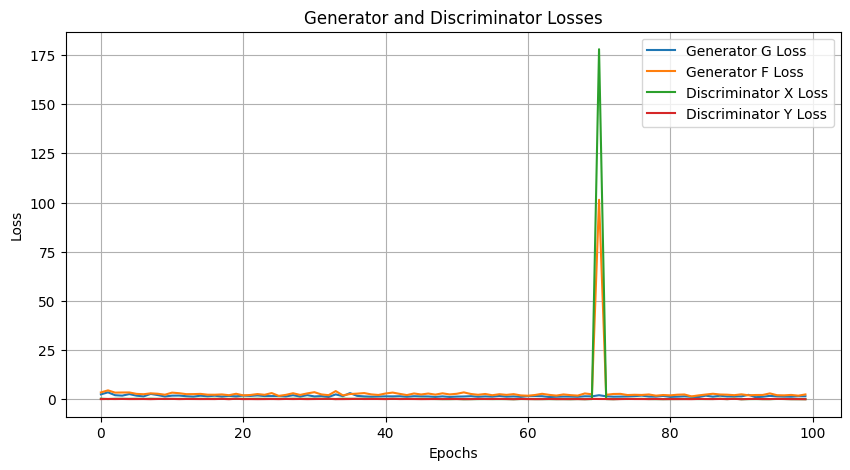

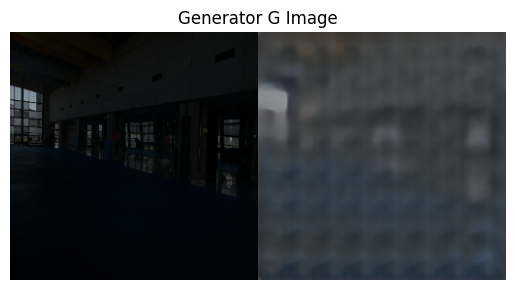

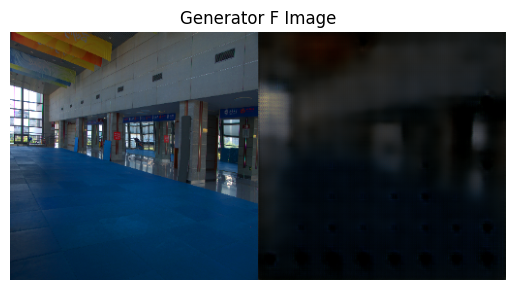

In [54]:
epochs = 100
lambda_cycle = 10.0
lambda_identity = 5.0


for epoch in range(epochs):
    clear_output(wait=True)
    
    for real_x, real_y in train_dataset:
        total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss = train_step(real_x, real_y, G, F, D_X, D_Y, lambda_cycle=10.0, lambda_identity=5.0)
    
    gen_g_losses.append(total_gen_g_loss.numpy())
    gen_f_losses.append(total_gen_f_loss.numpy())
    disc_x_losses.append(disc_x_loss.numpy())
    disc_y_losses.append(disc_y_loss.numpy())
    
    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Generator G Loss: {total_gen_g_loss}, Generator F Loss: {total_gen_f_loss}')
    print(f'Discriminator X Loss: {disc_x_loss}, Discriminator Y Loss: {disc_y_loss}')
    
    loss_plot(gen_g_losses,gen_f_losses,disc_x_losses,disc_y_losses,epoch)
    
    plot_generated_images(G,example_real_x,'Generator G Image')
    plot_generated_images(F,example_real_y,'Generator F Image')
    


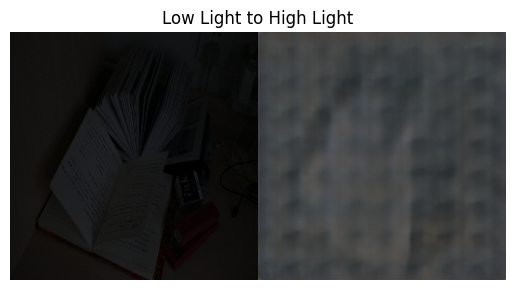

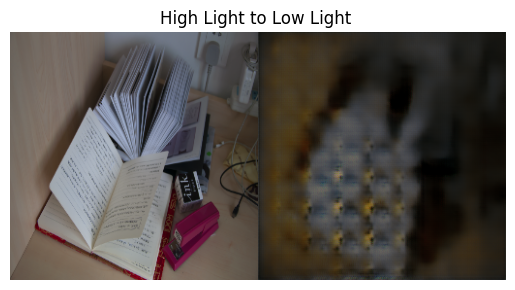

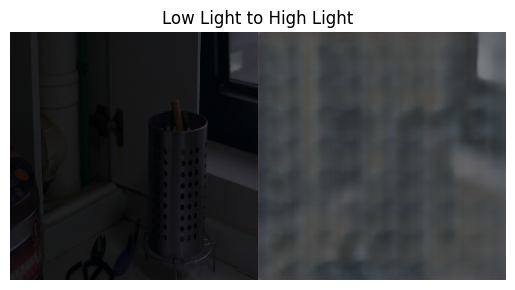

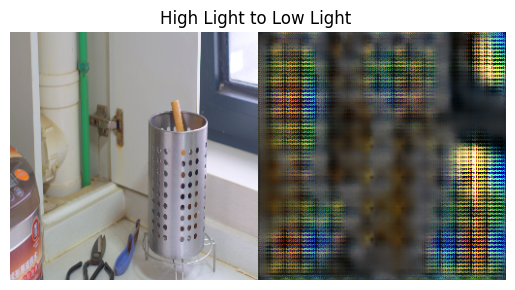

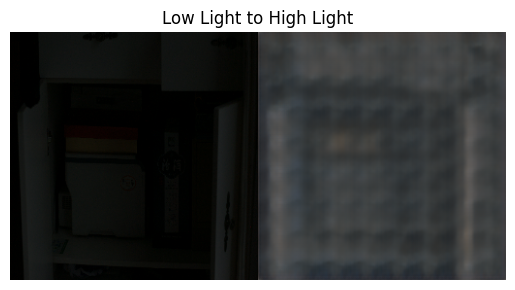

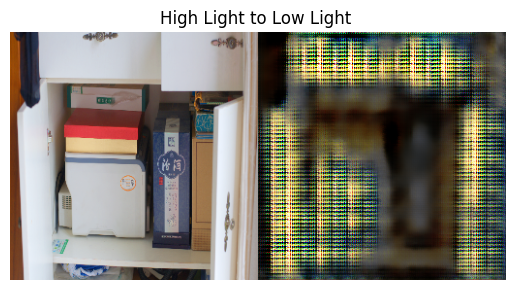

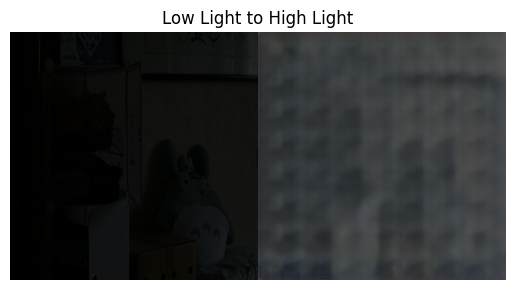

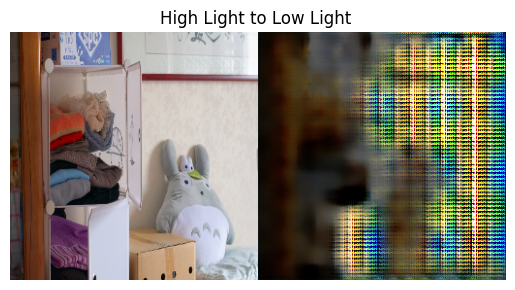

In [55]:
from random import randint
for i in range(0,4):
    
    l=randint(0,14)
    
    example_real_x=val_low_images[l]
    example_real_y=val_high_images[l]

    plot_generated_images(G,example_real_x,'Low Light to High Light')
    plot_generated_images(F,example_real_y,'High Light to Low Light ')
    
